<a href="https://colab.research.google.com/github/chrisfeltner/feltner-cop4630/blob/master/HW3/ChristopherFeltnerHomeworkThree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homework Three
##Christopher Feltner

###Check GPU Type

In [14]:
from tensorflow.python.client import device_lib
for x in device_lib.list_local_devices():
   if x.device_type == "GPU":
     print("***** GPU Information *****")
     print("Device Name: " , x.name)
     print("Memory Limit: " , "%.2f" % float(x.memory_limit/(1000*1000*1000)), "GB")
     print("Description: " , x.physical_device_desc)

***** GPU Information *****
Device Name:  /device:GPU:0
Memory Limit:  15.96 GB
Description:  device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [2]:
# imports
import os
from keras.applications import NASNetLarge
from keras import models, layers, optimizers, backend
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer

Using TensorFlow backend.


#Google Drive I/O

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/My\ Drive/AI\ Class/RuTanks7000_v1.zip ./
!unzip -q RuTanks7000_v1.zip
!find ./RuTanks7000_v1 -name "*.DS_Store" -type f -delete
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive  RuTanks7000_v1  RuTanks7000_v1.zip  sample_data


In [4]:
!ls RuTanks7000_v1

test  train


#Set Parameters

In [5]:
# Setting Parameters ##################################################################
# image settings
img_height,img_width = 331, 331  # For NASNetLarge

# classes
classnames = ["Background", "BMP2", "Buk-M1-2", "T14", "T90", "ZSU23"]
classes = len(classnames)

# path settings
path = ''
dataset_path = path+'RuTanks7000_v1/'
weights_path = path+'trained_models/trained_weights/weights_temp.h5'
model_path = path+'trained_models/RuTanks7000_v1_'
TensorBoardLogDir = path+'logs'

nbrTrainImages = 7000  # per class
nbrTestImages = 0  # Value gets accurate after counting (Total Number of test images)
for ImagesClass in os.listdir(dataset_path+'test/'):
    nbrTestImages += len(os.listdir(dataset_path+'test/'+ImagesClass))
    
print(nbrTestImages)
# unfreezing the base network up to a specific layer in Level2:
freezeUptoLayer = "normal_add_1_15"   # NASNetLarge

# hyperparameters
learning_rate = 0.0002  # Learning_rate in Level 2 = learning_rate/10
lr_decay = 0.0001
batch = 120
fcLayer1 = 32
dropout = 0.5

epochsL1 = 10
patiencel1 = 1
factorL1 = 0.5

epochsL2 = 10
patiencel2 = 1
factorL2 = 0.5

verbose_train = 1

# datagenerators https://keras.io/preprocessing/image/
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    dataset_path+'train',
    target_size=(img_height, img_width),
    batch_size=batch,
    shuffle=True,
    classes=classnames,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    dataset_path+'test',
    target_size=(img_height, img_width),
    batch_size=1,
    shuffle=True,
    classes=classnames,
    class_mode='categorical')
#########################################################################################

90
Found 42000 images belonging to 6 classes.
Found 90 images belonging to 6 classes.


In [6]:
!ls
!mkdir ./trained_models
!mkdir ./trained_models/trained_weights
!mkdir ./trained_models/RuTanks7000_v1_

drive  RuTanks7000_v1  RuTanks7000_v1.zip  sample_data


#Plot Function Definition

In [0]:
# function to plot results of model performance
def plot(h,t,e):
    history_dict = h[0]
    loss_values = history_dict['loss']
    validation_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    validation_acc_values = history_dict['val_acc']
    epochs_range = range(1, e + 1)

    # Plotting Training and Validation loss of the corresponding Model
    plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
    plt.plot(epochs_range, validation_loss_values, 'ro', label='Validation loss')
    plt.title('Training and validation loss of ' + t)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0, 3.1, step=0.2))
    plt.legend()
    plt.show()

    # Plotting Training and Validation accuracy of the corresponding Model
    plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
    plt.plot(epochs_range, validation_acc_values, 'ro', label='Validation accuracy')
    plt.title('Training and validation accuracy of ' + t)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0.3, 1.1, step=0.1))
    plt.legend()
    plt.show()

#L1















343613440/343610240 [==============================] - 8s 0us/step

### LEVEL1 ###
pretrained network:
Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 165, 165, 96) 0           stem_bn1[0

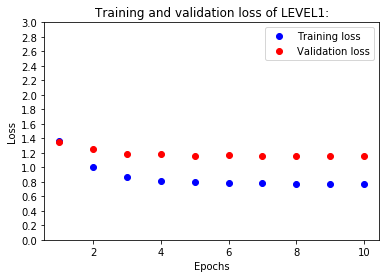

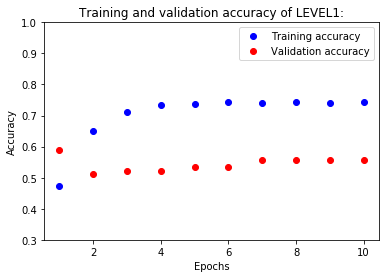


### LEVEL1 Training finished successfully ###

Loading trained weights from trained_models/trained_weights/weights_temp.h5 ...

### Saving Level1 Model to  trained_models/RuTanks7000_v1_l1.h5  ... 


In [9]:
  # Building the model using the pretrained model
  conv_base1 = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
  print("\n### LEVEL1 ###\npretrained network:")
  conv_base1.summary()
  model = models.Sequential()
  model.add(conv_base1)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(fcLayer1, activation='relu'))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(classes, activation='softmax'))

  # freezing the base network
  print("trainable layers before freezing:", int(len(model.trainable_weights)/2)) # weights = weights + bias = 2 pro layer
  conv_base1.trainable = False
  print("trainable layers after freezing:", int(len(model.trainable_weights)/2))
  print("\npretrained network + densely connected classifier")
  model.summary()

  # training the added layers only
  model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate, decay=lr_decay), metrics=['acc'])

  callbacks_list_L1 = [ModelCheckpoint(filepath=weights_path, save_weights_only=True, monitor='val_acc', verbose=1, save_best_only=True),
                    ReduceLROnPlateau(monitor='val_acc', factor=factorL1, patience=patiencel1, verbose=1),
                    TensorBoard(log_dir=TensorBoardLogDir+'\\level1')]

  print("\n### Level1 Training ... ")
  # training the model
  history = model.fit_generator(
      train_generator,
      steps_per_epoch=(nbrTrainImages * classes) // (batch * 5),
      epochs=epochsL1,
      callbacks=callbacks_list_L1,
      validation_data=test_generator,
      validation_steps=nbrTestImages,
      verbose=verbose_train)

  history_val1 = [history.history]  # saving all results of the final test
  plot(history_val1, "LEVEL1:", epochsL1)
  print("\n### LEVEL1 Training finished successfully ###")

  print("\nLoading trained weights from " + weights_path + " ...")
  model.load_weights(weights_path)
  model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate), metrics=['acc'])
  print("\n### Saving Level1 Model to ", model_path+'l1.h5', " ... ")
  model.save(model_path+'l1.h5')

#L2

In [10]:
backend.clear_session()
print("\n### LEVEL2 ###")
conv_base2 = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
model2 = models.Sequential()
model2.add(conv_base2)
model2.add(layers.GlobalAveragePooling2D())
model2.add(layers.Dense(fcLayer1, activation='relu'))
model2.add(layers.Dropout(dropout))
model2.add(layers.Dense(classes, activation='softmax'))

print("\nLoading trained weights from " + weights_path + " ...")
model2.load_weights(weights_path)

# unfreezing the base network up to a specific layer:
if freezeUptoLayer == "":
    conv_base2.trainable = True
    print ("\ntrainable layers: ",int(len(model2.trainable_weights) / 2))
else:
    print("\ntrainable layers before unfreezing the base network up to " + freezeUptoLayer + ": ",int(len(model2.trainable_weights) / 2))  # weights = weights + bias = 2 pro layer
    conv_base2.trainable = True
    set_trainable = False
    for layer in conv_base2.layers:
        if layer.name == freezeUptoLayer: set_trainable = True
        if set_trainable: layer.trainable = True
        else: layer.trainable = False
    print("trainable layers after the base network unfreezed from layer " + freezeUptoLayer + ": ", int(len(model2.trainable_weights)/2))

print("\nLEVEL2 Model after unfreezing the base network")
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate/10, decay=lr_decay), metrics=['acc'])
print ("\n### Validating ... ")

val_loss, val_acc = model2.evaluate_generator(test_generator, steps=nbrTestImages, verbose=0)
print('Validation Results before training unfreeze layers and trained densely connected layers:\nValidation loss:',val_loss,",",'Validation accuracy:', val_acc, "\n")

# Jointly training both the unfreeze layers and the added trained densely connected layers
callbacks_list_L2 = [ModelCheckpoint(filepath=model_path+'l2.h5', save_weights_only=False, monitor='val_acc', verbose=1, save_best_only=True),
                  ReduceLROnPlateau(monitor='val_acc', factor=factorL2, patience=patiencel2, verbose=1),
                  TensorBoard(log_dir=TensorBoardLogDir+'\\level2')]

print ("\n### Level2 Training ... ")
history = model2.fit_generator(
    train_generator,
    steps_per_epoch=(nbrTrainImages * classes) // (batch * 5),
    epochs=epochsL2,
    callbacks=callbacks_list_L2,
    validation_data=test_generator,
    validation_steps=nbrTestImages,
    verbose=verbose_train)
history_val2 = [history.history]  # saving all results of the final test



### LEVEL2 ###

Loading trained weights from trained_models/trained_weights/weights_temp.h5 ...

trainable layers before unfreezing the base network up to normal_add_1_15:  510
trainable layers after the base network unfreezed from layer normal_add_1_15:  71

LEVEL2 Model after unfreezing the base network
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 4032)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                129056    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (

#Results

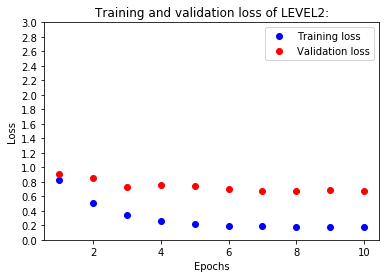

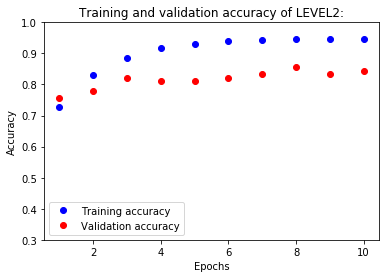


###LEVEL2 Training finished successfully ###


In [13]:

plot(history_val2, "LEVEL2:", epochsL2)
print("\n###LEVEL2 Training finished successfully ###")

##Analysis Func Definitions

In [0]:
def analysis():
    # testing the model
    print("\n### Testing the loaded model ... ")
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=nbrTestImages, verbose=1)
    print('Test Results of the trained Model:\nTest loss:', test_loss, ",", 'test accuracy:', test_acc)

    # Confusion Matrix and Classification Report
    pred_argmax = np.argmax(pred, axis=1)
    print('\nConfusion Matrix')
    print(confusion_matrix(test_generator.classes, pred_argmax))
    print('\nClassification Report')
    print(classification_report(test_generator.classes, pred_argmax, target_names=classnames))

    # t-SNE Visualization: t-Distributed Stochastic Neighbor Embedding (t-SNE) for visualizing high-dimensional data.
    img_tensors = []
    for i in range(len(test_images)):
        pred_img = image.load_img(test_images_path[i], target_size=(331, 331))
        img_tensor = image.img_to_array(pred_img)
        img_tensor = np.expand_dims(img_tensor, axis=0)
        img_tensor /= 255.
        img_tensors.append(img_tensor)

    # Last conv layer
    layer = model.get_layer('dense_1')
    layer_output = layer.output
    activation_model = models.Model(input=model.input, outputs=[layer_output])

    img_tensors = np.asarray(img_tensors)
    img_tensors_array = np.concatenate((img_tensors))
    print("img_tensors_array.shape=", img_tensors_array.shape)

    activations = activation_model.predict(img_tensors_array)
    print("activations.shape=", activations.shape)


def plot_images():
    # plotting test images with class predictions as title
    print("\nClass Predictions of test images from", test_path)
    for k in range(len(test_images)):
        predictions = []
        for l in range(len(classnames)):
            predictions.append((np.round(pred[k][l] * 100, 2), classnames[l]))
        predictions.sort(reverse=True)
        print("Image", k + 1, ":", predictions)

        plt.figure(figsize=(8, 8))  # width, height in inches.
        plt.style.use('dark_background')
        plt.suptitle("Class prediction of a " + true_labels_class[k] + " image" + "\n(Test image " + str(k + 1) + ")", fontsize=18)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        legend_string = "Prediction: " + \
                        "\n%.2f" % predictions[0][0] + "% " + predictions[0][1] + \
                        "\n%.2f" % predictions[1][0] + "% " + predictions[1][1] + \
                        "\n%.2f" % predictions[2][0] + "% " + predictions[2][1] + \
                        "\n%.2f" % predictions[3][0] + "% " + predictions[3][1] + \
                        "\n%.2f" % predictions[4][0] + "% " + predictions[4][1] + \
                        "\n%.2f" % predictions[5][0] + "% " + predictions[5][1] + \
                        "\n%.2f" % predictions[6][0] + "% " + predictions[6][1]
        plt.text(img_width + 10, 125, legend_string, fontsize=16)
        plt.imshow(test_images[k])
        plt.show()

In [20]:
!ls trained_models/

RuTanks7000_v1_  RuTanks7000_v1_l1.h5  RuTanks7000_v1_l2.h5  trained_weights


In [34]:
path = ''
test_path = path+'RuTanks7000_v1/test/'
model_path = path+'trained_models/RuTanks7000_v1_l2.h5'

test_images = []
for i in range(nbrTestImages):
    test_images.append(test_generator.next()[0][0])

test_images_path = []
true_labels = []
true_labels_class = []

test_images_Background = os.listdir(test_path + 'Background')
for imagefile in test_images_Background:
    test_images_path.append(test_path + 'Background/' + imagefile)
    true_labels.append(0)
    true_labels_class.append('Background')

test_images_BMP2 = os.listdir(test_path + 'BMP2')
for imagefile in test_images_BMP2:
    test_images_path.append(test_path + 'BMP2/' + imagefile)
    true_labels.append(1)
    true_labels_class.append('BMP2')

test_images_Buk = os.listdir(test_path + 'Buk-M1-2')
for imagefile in test_images_Buk:
    test_images_path.append(test_path + 'Buk-M1-2/' + imagefile)
    true_labels.append(2)
    true_labels_class.append('Buk-M1-2')

test_images_T14 = os.listdir(test_path + 'T14')
for imagefile in test_images_T14:
    test_images_path.append(test_path + 'T14/' + imagefile)
    true_labels.append(4)
    true_labels_class.append('T14')

test_images_T90 = os.listdir(test_path + 'T90')
for imagefile in test_images_T90:
    test_images_path.append(test_path + 'T90/' + imagefile)
    true_labels.append(5)
    true_labels_class.append('T90')

test_images_ZSU23 = os.listdir(test_path + 'ZSU23')
for imagefile in test_images_ZSU23:
    test_images_path.append(test_path + 'ZSU23/' + imagefile)
    true_labels.append(6)
    true_labels_class.append('ZSU23')


# Returns the compiled model identical to the previously saved one
print("Loading the trained model from " + model_path + " ...\n")
model = models.load_model(model_path)
print("\nTrained model " + model_path + ":")
model.summary()

# predicting labels
pred = model.predict_generator(test_generator, nbrTestImages)
print("Dataset at", test_path, "has", pred.shape[0], "images with", pred.shape[1], "class predictions each")


Loading the trained model from trained_models/RuTanks7000_v1_l2.h5 ...


Trained model trained_models/RuTanks7000_v1_l2.h5:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 4032)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                129056    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 85,046,072
Trainable params: 30,292,646
Non-trainable params: 54,753,426
_________________________________________

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image
from sklearn.manifold import TSNE
import seaborn as sns

#Analysis of NASNet

In [32]:
analysis()


### Testing the loaded model ... 
90/90 [==============================] - 6s 70ms/step
Test Results of the trained Model:
Test loss: 0.6691087129626087 , test accuracy: 0.8555555555555555

Confusion Matrix
[[1 3 3 3 4 1]
 [2 2 2 2 2 5]
 [5 1 5 0 2 2]
 [3 3 6 0 1 2]
 [4 2 3 2 3 1]
 [1 2 2 4 3 3]]

Classification Report
              precision    recall  f1-score   support

  Background       0.06      0.07      0.06        15
        BMP2       0.15      0.13      0.14        15
    Buk-M1-2       0.24      0.33      0.28        15
         T14       0.00      0.00      0.00        15
         T90       0.20      0.20      0.20        15
       ZSU23       0.21      0.20      0.21        15

    accuracy                           0.16        90
   macro avg       0.14      0.16      0.15        90
weighted avg       0.14      0.16      0.15        90



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("NA...)`


img_tensors_array.shape= (90, 331, 331, 3)
activations.shape= (90, 32)


#Fine-Tuning InceptionV3
###Increased batch size

##L1

In [0]:
from keras.applications.inception_v3 import InceptionV3

In [38]:
conv_base1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
print("\n### LEVEL1 ###\npretrained network:")
conv_base1.summary()
model = models.Sequential()
model.add(conv_base1)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(fcLayer1, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(classes, activation='softmax'))

87916544/87910968 [==============================] - 2s 0us/step

### LEVEL1 ###
pretrained network:
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 165, 165, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 165, 165, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_261 (Activation)     (None, 165, 165, 32) 0           batch_normalization_

In [42]:
# freezing the base network
print("trainable layers before freezing:", int(len(model.trainable_weights)/2)) # weights = weights + bias = 2 pro layer
conv_base1.trainable = False
print("trainable layers after freezing:", int(len(model.trainable_weights)/2))
print("\npretrained network + densely connected classifier")
model.summary()

trainable layers before freezing: 96
trainable layers after freezing: 2

pretrained network + densely connected classifier
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 9, 9, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                65568     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 21,868,550
Trainable params: 65,766
Non-trainable params: 21,802,784
______________________________________________

In [41]:
!ls trained_models/trained_weights/
!mkdir ./trained_models/trained_weights/InceptionV3/

weights_temp.h5


### Changing Parameters

In [0]:
weights_path = path + 'trained_models/trained_weights/InceptionV3/weights_temp.h5'
model_path = path+'trained_models/RuTanks7000_v1_Inception'
batch=128


### Level1 Training ... InceptionV3 Model
Epoch 1/10
65/65 [==============================] - 184s 3s/step - loss: 1.6359 - acc: 0.3321 - val_loss: 1.6364 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to trained_models/trained_weights/InceptionV3/weights_temp.h5
Epoch 2/10
65/65 [==============================] - 145s 2s/step - loss: 1.3812 - acc: 0.4813 - val_loss: 1.5316 - val_acc: 0.3889

Epoch 00002: val_acc improved from 0.33333 to 0.38889, saving model to trained_models/trained_weights/InceptionV3/weights_temp.h5
Epoch 3/10
65/65 [==============================] - 168s 3s/step - loss: 1.2231 - acc: 0.5588 - val_loss: 1.4558 - val_acc: 0.4222

Epoch 00003: val_acc improved from 0.38889 to 0.42222, saving model to trained_models/trained_weights/InceptionV3/weights_temp.h5
Epoch 4/10
65/65 [==============================] - 168s 3s/step - loss: 1.1119 - acc: 0.6065 - val_loss: 1.3880 - val_acc: 0.4222

Epoch 00004: val_acc did not improve from 

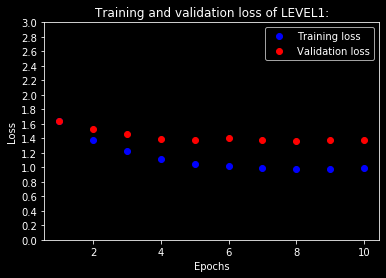

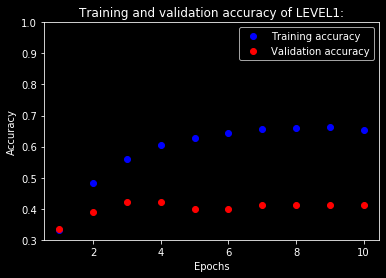


### LEVEL1 Training finished successfully ###

Loading trained weights from trained_models/trained_weights/InceptionV3/weights_temp.h5 ...

### Saving Level1 Model to  trained_models/RuTanks7000_v1_Inceptionl1.h5  ... 


In [46]:
# training the added layers only
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate, decay=lr_decay), metrics=['acc'])

callbacks_list_L1 = [ModelCheckpoint(filepath=weights_path, save_weights_only=True, monitor='val_acc', verbose=1, save_best_only=True),
                  ReduceLROnPlateau(monitor='val_acc', factor=factorL1, patience=patiencel1, verbose=1),
                  TensorBoard(log_dir=TensorBoardLogDir+'\\level1')]

print("\n### Level1 Training ... InceptionV3 Model")
# training the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=(nbrTrainImages * classes) // (batch * 5),
    epochs=epochsL1,
    callbacks=callbacks_list_L1,
    validation_data=test_generator,
    validation_steps=nbrTestImages,
    verbose=verbose_train)

history_val1 = [history.history]  # saving all results of the final test
plot(history_val1, "LEVEL1:", epochsL1)
print("\n### LEVEL1 Training finished successfully ###")

print("\nLoading trained weights from " + weights_path + " ...")
model.load_weights(weights_path)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate), metrics=['acc'])
print("\n### Saving Level1 Model to ", model_path+'l1.h5', " ... ")
model.save(model_path+'l1.h5')

In [51]:
backend.clear_session()
print("\n### LEVEL2 ###")
conv_base2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
model2 = models.Sequential()
model2.add(conv_base2)
model2.add(layers.GlobalAveragePooling2D())
model2.add(layers.Dense(fcLayer1, activation='relu'))
model2.add(layers.Dropout(dropout))
model2.add(layers.Dense(classes, activation='softmax'))

print("\nLoading trained weights from " + weights_path + " ...")
model2.load_weights(weights_path)

for layer in conv_base2.layers[:249]:
   layer.trainable = False
for layer in conv_base2.layers[249:]:
   layer.trainable = True

print("\nLEVEL2 Model after unfreezing the base network")
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate/10, decay=lr_decay), metrics=['acc'])
print ("\n### Validating ... ")

val_loss, val_acc = model2.evaluate_generator(test_generator, steps=nbrTestImages, verbose=0)
print('Validation Results before training unfreeze layers and trained densely connected layers:\nValidation loss:',val_loss,",",'Validation accuracy:', val_acc, "\n")

# Jointly training both the unfreeze layers and the added trained densely connected layers
callbacks_list_L2 = [ModelCheckpoint(filepath=model_path+'l2.h5', save_weights_only=False, monitor='val_acc', verbose=1, save_best_only=True),
                  ReduceLROnPlateau(monitor='val_acc', factor=factorL2, patience=patiencel2, verbose=1),
                  TensorBoard(log_dir=TensorBoardLogDir+'\\level2')]

print ("\n### Level2 Training ... ")
history = model2.fit_generator(
    train_generator,
    steps_per_epoch=(nbrTrainImages * classes) // (batch * 5),
    epochs=epochsL2,
    callbacks=callbacks_list_L2,
    validation_data=test_generator,
    validation_steps=nbrTestImages,
    verbose=verbose_train)
history_val2 = [history.history]  # saving all results of the final test


### LEVEL2 ###

Loading trained weights from trained_models/trained_weights/InceptionV3/weights_temp.h5 ...

LEVEL2 Model after unfreezing the base network
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 9, 9, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                65568     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 21,868,550
Trainable params: 11,180,646
Non-trainable params: 10,687,904
________

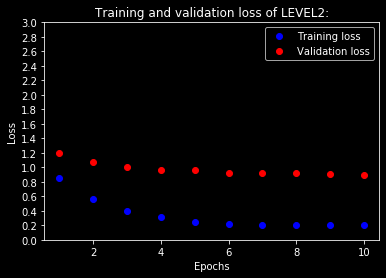

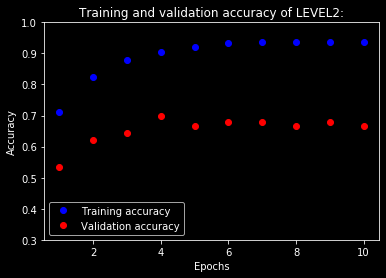


###LEVEL2 Training finished successfully ###


In [52]:

plot(history_val2, "LEVEL2:", epochsL2)
print("\n###LEVEL2 Training finished successfully ###")